# Implementation

```{contents}
:local:
```

## Utilities

In [1]:
import sys
from pathlib import Path
parent_dir = str(Path().resolve().parents[3])
sys.path.append(parent_dir)

import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

from omnivault.utils.reproducibility.seed import seed_all
def true_pmf(x: float, population: np.ndarray) -> float:
    r"""PMF of the true population: map X(\S) to a probability.

    Note:
        The PMF is completely determined if we know the true distribution.
    """
    return np.sum(population == x) / len(population)


def empirical_pmf(x: float, sample: np.ndarray) -> float:
    """Empirical distribution of the sample."""
    return np.sum(sample == x) / len(sample)

In [2]:
_ = seed_all(42, set_torch_deterministic=False)

Using Seed Number 42


## The Setup

We will use the same setup in {doc}`../bernoulli/0308_bernoulli_distribution_concept`.

Let the true population be defined as a total of $10000$ people. 

We will use the same disease modelling setup.

Let the experiment be a triplet $\pspace$, this experiment is the action of ***randomly selecting n people***
from the true population and subsequently finding out if $k$ of them have covid.
We also emphasize that the process of selecting $n$ independent and identically distributed people
corresponds to selecting $n$ independent Bernoulli trials, from the same Bernoulli distribution.
This means if $Y \sim \bern(p)$ is the Bernoulli random variable denoting the probability
distribution of whether a person has covid or not, then if we repeat this $Y$ $n$ number of
times independently (drawn with replacement), then we will have a sequence of random variables $Y_0, Y_1, \ldots, Y_n$,
all of which fulfills **i.i.d.** simply because $Y_i$ comes from the same distribution $Y$,
and independent because we draw each sample randomly with replacement. Note there should be 
no ambiguity that $Y_i$ are copies of the distribution $Y$, and each copy $Y_i$ corresponds to 
the new random draw. The sum $Y = Y_0 + Y_1 + \ldots + Y_n$, denoted as $Y$ again (with no confusion
with the $Y$ defined earlier), has a Binomial distribution with parameter $p$ from the Bernoulli distribution
and $n$ being the number of trials.

Since our problem finding the number of people ($k$) who is covid positive out of $n$ people, 
we define our **sample space** to be $\Omega = \{0, 1, \ldots, n\}$. This is easy to see because
out of $n$ people, with success being 1 and failure being 0, then the sum of these $n$
trials can at most be $n = \underbrace{1 + 1 + \ldots + 1}_{\text{n times}}$, at its worst,
it can be just $0$ times. The former is out of $n$ people, all $n$ has covid, the latter being
out of $n$ people, none has covid.

Now suppose I want to answer a few simple questions about the experiment. For example, I want to know

1. What is the probability of 2 people out of $n=10$ people has covid?
2. What is the expected value of the true population?

Since we have defined $Y$ earlier, the corresponding state space $Y(\S)$ is $\{0, 1, \ldots, n\}$.
We can associate each state
$y \in Y(\S)$ with a probability $P(Y = y)$. This is the ***probability mass function*** (PMF) of $Y$.

$$
\begin{align}
\P(Y=y) = \begin{cases}
p_1   &\quad \text{ if } y=0 \\
p_2   &\quad \text{ if } y=1 \\
\vdots \\
p_n   &\quad \text{ if } y=n
\end{cases}
\end{align}
$$

and we seek to find $p$, and since we already know the true population with $p=0.2$,
we can plot an ideal histogram to see the distribution of how the covid-status of each person in the true population is distributed.
An important reminder is that in real world, we often won't know the true population, and therefore ***estimating/inferencing*** the
$p$ parameter becomes important. Also, although there are two parameters, we often will have $n$ fixed and [estimate](https://en.wikipedia.org/wiki/Binomial_distribution#Estimation_of_parameters) $p$.

## The PMF (Ideal Histogram)

In [3]:
# create a true population of 1000 people of 200 1s and 800 0s
true_population = np.zeros(shape=10000)
true_population[:2000] = 1

See the plot of PMF for $p=0.2$ and $n=10$.
This means we are drawing 10 people from the true population 
in i.i.d. fashion, and the true PMF should be something like the below.

[1.07374182e-01 2.68435456e-01 3.01989888e-01 2.01326592e-01
 8.80803840e-02 2.64241152e-02 5.50502400e-03 7.86432000e-04
 7.37280000e-05 4.09600000e-06 1.02400000e-07]


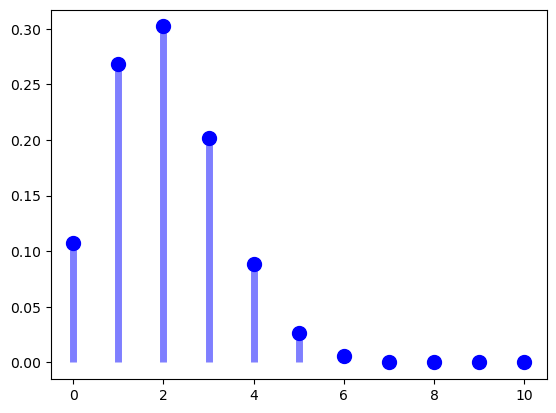

In [10]:
p = 0.2
n = 10
Y = stats.binom(n,p) # the Y ~ Binomial(n, p)
y = np.arange(11) # the states [0, 1, ..., 10]
f = Y.pmf(y) # pmf function
print(f)
plt.plot(y, f, 'bo', ms=10)
plt.vlines(y, 0, f, colors='b', lw=5, alpha=0.5);

(FIXME): Now I did not use the way in the previous sections because I do not how to plot out this distribution above using the `true_population`.

But first we must ackowledge this true PMF plotted above is correct.

We can verify by hand that the probability is correct, for example
the probability of $0$ people have covid out of 10 people is
like having 10 tails in a row where tails is no covid and heads is covid.

Then it is like

$$
\P \lsq \lset T, T, T, T, T, T, T, T, T, T \rset \rsq = 0.8^{10}
$$

we know this must be true because we know each $Y_i$ follows a Bernoulli distribution $Y_i \sim \bern(p=0.2)$
and since these are all independent, by basic probability, then the true probability for this is
indeed $\P(Y_i = T)$ multipled by 10 times.

In [16]:
0.8**10

0.10737418240000006

In [6]:
Y.pmf(0) # verified with hand calculation

0.10737418240000006

If we want to find $\P \lsq Y = 3 \rsq$, then it is like flipping coin 10 times and get
3 heads out of 10.

Which is 120 cases... since $10$ choose $3$ is 120 such cases. And for
each case, the probability is $0.2^{3} \times 0.8^{7}$, so the answer is 

$$
\P \lsq Y=3 \rsq = 120 \times 0.2^{3} \times 0.8^{7} = 0.2013265920000001
$$

In [11]:
120 * (0.2**3 * 0.8 ** 7)

0.2013265920000001

In [12]:
Y.pmf(3)

0.20132659199999992

The true pmf (ideal histogram) gives the answer that out of the true population, if $n=10$ and $p=0.2$,
the true PMF is realized as:

$$
\begin{align}
\P(Y=y) = \begin{cases}
0.107...   &\quad \text{ if } y=0 \\
0.268...   &\quad \text{ if } y=1 \\
\vdots \\
1.02e-07   &\quad \text{ if } y=10
\end{cases}
\end{align}
$$

In [13]:
for y in range(11):
    print(f"PMF for Y={y} is {Y.pmf(y)}")

PMF for Y=0 is 0.10737418240000006
PMF for Y=1 is 0.26843545599999996
PMF for Y=2 is 0.30198988800000004
PMF for Y=3 is 0.20132659199999992
PMF for Y=4 is 0.0880803839999999
PMF for Y=5 is 0.026424115199999983
PMF for Y=6 is 0.005505024000000005
PMF for Y=7 is 0.000786432
PMF for Y=8 is 7.372800000000001e-05
PMF for Y=9 is 4.095999999999997e-06
PMF for Y=10 is 1.0240000000000006e-07


## Empirical Distribution (Empirical Histograms)

In [28]:
sample_100 = np.random.choice(true_population, 100, replace=True)
sample_500 = np.random.choice(true_population, 500, replace=True)
sample_900 = np.random.choice(true_population, 900, replace=True)

In [41]:
def perform_bernoulli_trials(n: int, p: float):
    """
    Perform n Bernoulli trials with success probability p
    and return number of successes. That is to say:
    If I toss coin 10 times, and landed head 7 times, then success rate is
    70% -> this is what I should return. But note this is binary.
    """
    # Initialize number of successes: n_success
    n_success = 0
    rng = np.random.default_rng()

    # Perform trials
    for i in range(n):
        # Choose random number between zero and one: random_number
        random_number = rng.random(size=None)
        # If less than p, it's a success so add one to n_success
        if random_number < p:
            n_success += 1

    return n_success

In [47]:
def perform_bernoulli_trials(population: np.ndarray, n: int, p: float):
    """
    Perform n Bernoulli trials with success probability p
    and return number of successes. That is to say:
    If I toss coin 10 times, and landed head 7 times, then success rate is
    70% -> this is what I should return. But note this is binary.
    """
    # Initialize number of successes: n_success
    n_success = 0

    for i in range(n):
        # Choose random number between zero and one: random_number
        random_number = np.random.choice(population, size=None, replace=True, p=None)
        # If less than p, it's a success so add one to n_success
        if random_number == 1:
            n_success += 1

    return n_success

In [48]:
n_repeats = 100
n_covid = np.empty(shape=n_repeats)
for i in range(n_repeats):
    n_covid[i] = perform_bernoulli_trials(true_population, 10, 0.2)

In [49]:
n_covid

array([5., 3., 1., 6., 3., 2., 3., 2., 2., 4., 2., 1., 2., 0., 7., 3., 3.,
       0., 2., 2., 1., 3., 2., 3., 1., 2., 1., 2., 1., 1., 1., 2., 2., 3.,
       3., 2., 3., 2., 1., 2., 3., 2., 1., 2., 2., 1., 0., 2., 3., 1., 2.,
       3., 1., 2., 0., 2., 1., 3., 0., 2., 0., 3., 1., 1., 2., 1., 3., 2.,
       0., 4., 0., 3., 0., 2., 5., 2., 2., 3., 5., 3., 1., 1., 1., 2., 5.,
       2., 4., 1., 1., 2., 4., 3., 2., 1., 2., 0., 3., 2., 1., 4.])

(array([0.098, 0.259, 0.291, 0.22 , 0.093, 0.032, 0.006, 0.001]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5]),
 <a list of 8 Patch objects>)

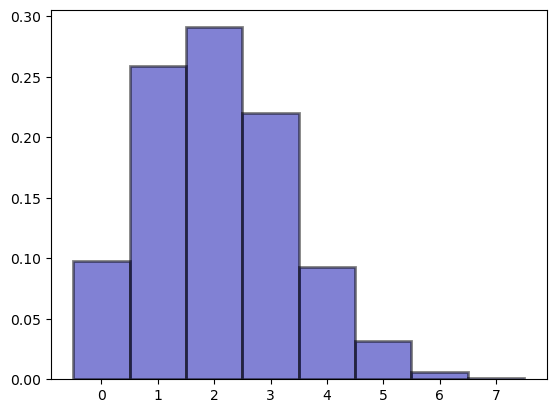

In [54]:
bins = np.arange(0, n_covid.max() + 1.5) - 0.5

plt.hist(
    n_covid,
    bins,
    density=True,
    color="#0504AA",
    alpha=0.5,
    edgecolor="black",
    linewidth=2,
)

In [57]:
n_repeats = 10000
n_covid = np.empty(shape=n_repeats)
for i in range(n_repeats):
    n_covid[i] = perform_bernoulli_trials(true_population, 10, 0.2)

(array([1.064e-01, 2.787e-01, 3.003e-01, 1.915e-01, 8.970e-02, 2.780e-02,
        4.800e-03, 7.000e-04, 1.000e-04]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
 <a list of 9 Patch objects>)

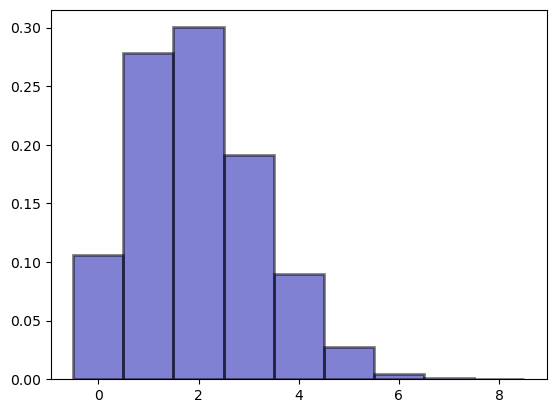

In [58]:
bins = np.arange(0, n_covid.max() + 1.5) - 0.5
plt.hist(
    n_covid,
    bins,
    density=True,
    color="#0504AA",
    alpha=0.5,
    edgecolor="black",
    linewidth=2,
)

## Further Readings

- https://www.youtube.com/watch?v=qIzC1-9PwQo&list=PLvxOuBpazmsNIHP5cz37oOPZx0JKyNszN&index=4
- https://towardsdatascience.com/fun-with-the-binomial-distribution-96a5ecabf65b